In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import astropy
import numpy as np
import jax
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Angle, EarthLocation
import astropy.units as u
from nsb2.instrument import HESS

from nyx.core.integrator import render
from nyx.core import Observation
from nyx.core.model import Model
from nyx.atmosphere import atmospheres
from nyx.instrument import instruments
from nyx.emitter import zodiacal, airglow, moon, stars

from nyx.core import get_wavelengths

# How to use mcmc to fit parameters:

## Building model:

In [4]:
# Instrument:
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

# Atmosphere:
oz = np.genfromtxt('absorption.txt')
oz_wvl, oz_tau = jnp.array(oz[:,0]), -np.log(jnp.array(oz[:,2]))
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        tau_absorption_func=lambda lam, h: jnp.interp(lam, oz_wvl, oz_tau) * jnp.exp(-(h-2.6)/7),
        hg_asymmetry=0.7
        )

# Emitters:
leinert = zodiacal.Leinert1998()
glow = airglow.ESOSkyCalc()
jones = moon.Jones2013()
gaia = stars.GaiaDR3(lim_mag=12)

# Combine to model:
pipeline = Model(HESS1, atmo, [glow, leinert, gaia, jones])

/usr/local/lib/python3.13/site-packages/astropy/units/quantity.py:1865: RuntimeWarning: All-NaN slice encountered
  result = super().__array_function__(function, types, args, kwargs)


## Creating an example observation:

In [85]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-11-14T02:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('crab nebula')
obs = Observation(location, obstime, target, rotation, fov=Angle(3*u.deg))

## Initializing scene:

In [87]:
scene = pipeline.query(obs)
initial_params = scene.get_initial_parameters()

/home/anonymous/ECAP/nyx/nyx/atmosphere/airmass.py:7: RuntimeWarning: invalid value encountered in scalar power
  return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))


In [88]:
scene.print_parameters(format='table')

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter    │ Shape │ Initial  │ Current │ Bounds │ Description                       │ 
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ aod_500      │ (1,)  │ 0.1000   │ -       │ -      │ AOD at 500nm                      │ 
│ atmosphere │ atmosphere │ angstrom_exp │ (1,)  │ 1.0000   │ -       │ -      │ Angstrom exponent                 │ 
│ atmosphere │ atmosphere │ hg_asymmetry │ (1,)  │ 0.7000   │ -       │ (0, 1) │ HG asymmetry                      │ 
│ instrument │ instrument │ eff          │ (1,)  │ 1.0000   │ -       │ -      │ Telescope efficiency in terms ... │ 
│ instrument │ instrument │ shift        │ (2,)  │ -        │ -       │ -      │ Pixel shift in rad                │ 
│ emitter_0  │ diffuse    │ sfu          │ (1,)  │ 100.000

## Creating a target image:

In [131]:
ground_truth = render(scene.realize(initial_params))

# Generating noisy image
log_std = np.log(1 + 0.0001)
noise = np.random.lognormal(mean=0, sigma=log_std, size=ground_truth.shape)

target_img = jnp.array(ground_truth * noise)

## Creating a loss function:

In [161]:
valid_mask = ~jnp.isnan(target_img)
arcs = 1/3600/180*jnp.pi

@jax.jit
def loss_fn(params):  
    scene_instance = scene.realize(params)
    pred = render(scene_instance)
    
    return (pred - target_img) / (0.1*target_img + 1e-11)

def residual(p):
    v = p.valuesdict()
    params = jnp.array((v['aod'], v['angstrom'], v['hg_asym'], v['eff'], v['xshift']*arcs, v['yshift']*arcs, v['sfu']))
    return loss_fn(params)

## Running lmfit:

In [123]:
import lmfit
p = lmfit.Parameters()
p.add_many(
    ('aod', 0.2, True, 0.01, 2.0), 
    ('angstrom', 1.2, True, 0.0, 3.0), 
    ('hg_asym', 0.7, True, 0.5, 1.0),
    ('eff', 1., True, 0.6, 1.2), 
    ('xshift', 0.0, True, -400, 400), 
    ('yshift', 0.0, True, -400, 400),
    ('sfu', 100, True, 60, 250),
)

# Initial fit to find start point
res = lmfit.minimize(residual, p, nan_policy='omit')
emcee_params = res.params.copy()

res = lmfit.minimize(residual, emcee_params, method='emcee', nan_policy='omit', burn=1000, steps=3000,
                     thin=20, nwalkers=30, is_weighted=True, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:54<00:00,  6.32it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [157.61403063 100.83353119 114.28391242 167.62286563 100.98002283
 120.56271995 156.17530645]


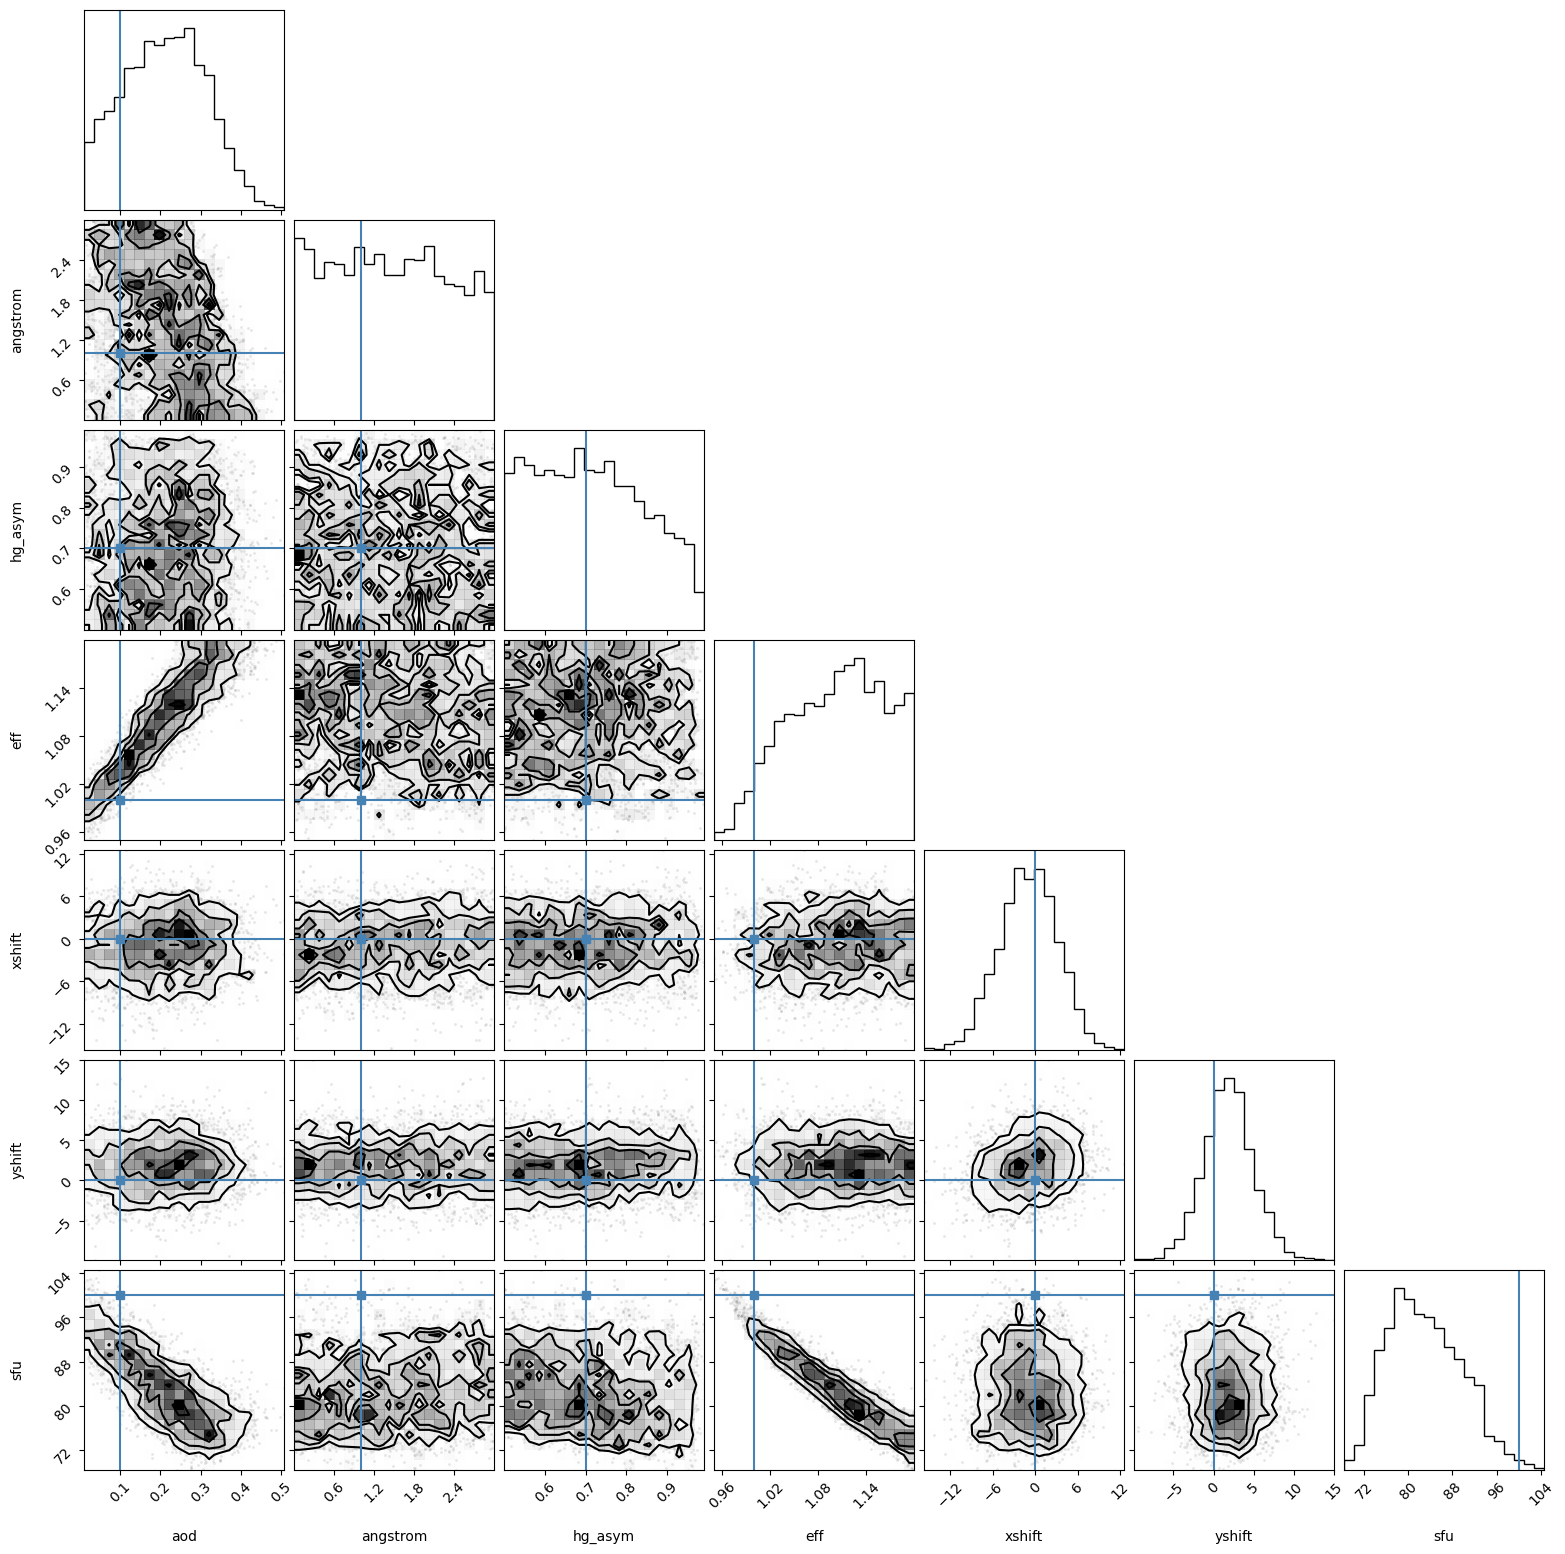

In [124]:
import corner
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=np.array(initial_params))